Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: [Dies Natalis Solis Invicti](https://en.wikipedia.org/wiki/Sol_Invictus)
* Reviews: [Befana](https://en.wikipedia.org/wiki/Befana)

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

###Got the game code from the Quixo code and just changed some stuff

In [41]:
from abc import ABC, abstractmethod
from copy import deepcopy
from enum import Enum
import numpy as np
import random as rand
from tqdm import tqdm
import matplotlib.pyplot as plt


# Rules on PDF

class Player(ABC):
    def __init__(self) -> None:
        '''You can change this for your player if you need to handle state/have memory'''
        pass

    @abstractmethod
    def make_move(self, game: 'Game') -> tuple[tuple[int, int]]:
        '''
        game: the Tris game. You can use it to override the current game with yours, but everything is evaluated by the main game
        return values: this method shall return a tuple of X,Y positions
        '''
        pass


class Game(object):
    def __init__(self) -> None:
        self._board = np.ones((3, 3), dtype=np.uint8) * -1

    def get_board(self):
        '''
        Returns the board
        '''
        return deepcopy(self._board)

    def print(self):
        '''Prints the board. -1 are neutral pieces, 0 are pieces of player 0, 1 pieces of player 1'''
        print(self._board)

    def check_winner(self) -> int:
        '''Check the winner. Returns the player ID of the winner if any, otherwise returns -1'''
        # for each row
        for x in range(self._board.shape[0]):
            # if a player has completed an entire row
            if self._board[x, 0] != -1 and all(self._board[x, :] == self._board[x, 0]):
                # return the relative id
                return self._board[x, 0]
        # for each column
        for y in range(self._board.shape[1]):
            # if a player has completed an entire column
            if self._board[0, y] != -1 and all(self._board[:, y] == self._board[0, y]):
                # return the relative id
                return self._board[0, y]
        # if a player has completed the principal diagonal
        if self._board[0, 0] != -1 and all(
            [self._board[x, x]
                for x in range(self._board.shape[0])] == self._board[0, 0]
        ):
            # return the relative id
            return self._board[0, 0]
        # if a player has completed the secondary diagonal
        if self._board[0, -1] != -1 and all(
            [self._board[x, -(x + 1)]
             for x in range(self._board.shape[0])] == self._board[0, -1]
        ):
            # return the relative id
            return self._board[0, -1]
        return -1

    def play(self, player1: Player, player2: Player) -> int:
        '''Play the game. Returns the winning player'''
        players = [player1, player2]
        current_player_idx = 1
        winner = -1
        while winner < 0:
            if -1 not in self.get_board().ravel():
              winner = -2
              break
            current_player_idx += 1
            current_player_idx %= len(players)
            ok = False
            while not ok:
                from_pos = players[current_player_idx].make_move(self)
                ok = self._move(from_pos, current_player_idx)
            winner = self.check_winner()
        return winner

    def _move(self, from_pos: tuple[int, int], player_id: int) -> bool:
        '''Perform a move'''
        if player_id > 2:
            return False
        # Oh God, Numpy arrays
        prev_value = deepcopy(self._board[(from_pos[1], from_pos[0])])

        acceptable = False
        if self._board[from_pos] < 0:
          self._board[from_pos] = player_id
          acceptable = True
        return acceptable

###Added a subclass for training

In [42]:
class TrainingGame(Game):
  def __init__(self) -> None:
    super().__init__()

  def play(self, player1: Player, player2: Player) -> int:
        '''Play the game. Returns the winning player'''
        players = [player1, player2]
        current_player_idx = 1
        winner = -1

        while winner < 0:
            if -1 not in self.get_board().ravel():
              winner =-2
              break
            #get board old state
            old_state = self.get_board()

            current_player_idx += 1
            current_player_idx %= len(players)
            ok = False
            while not ok:
                from_pos = players[current_player_idx].make_move(self)
                ok = self._move(from_pos, current_player_idx)
                if not ok and isinstance(players[current_player_idx], MyPlayer):
                  #my model contains also invalid moves so I wanna learn not to do them
                  invalid_move_state = self.get_board()
                  reward = players[current_player_idx].compute_reward(is_winner=-1 , new_state=invalid_move_state)
                  #print("rew", reward)
                  players[current_player_idx].get_experience(old_state, from_pos, reward, invalid_move_state, False )

            winner = self.check_winner()

            if isinstance(players[current_player_idx], MyPlayer):
              #get board new state
              new_state = self.get_board()
              #1 here the player should get the reward
              winval = 1 if winner == current_player_idx else (0 if winner == (current_player_idx + 1) % len(players) else -1)
              reward = players[current_player_idx].compute_reward( winval, new_state)
              #print("rew", reward, "winner", winner)
              #print("play as ", current_player_idx, ":",old_state.ravel(), "-",new_state.ravel())
              #2 here I would be capable of gettin my new step record, to put it into my replay memory
              players[current_player_idx].get_experience(old_state, from_pos, reward, new_state, winner!=-1 )
        return winner

In [43]:
class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: 'Game') -> tuple[tuple[int, int]]:
        from_pos = (rand.randint(0, 2), rand.randint(0, 2))
        return from_pos

###This is my model: I'll put it inside my player

###It's a double Q Learning Model based with Replay Memory

###MyPlayer can be created as untrained, and then it goes completely random.
###If created as trained, it will start training against RandomPlayer.
###Replay Memory uncorrelates discovery from learning, making exploration less biased by the learning policy.
###The usage of two different tables, for extimation and as target, avoid the model following its own tail, getting learning faster, if tuned properly.
###I also use a Discount Factor and a Learning Rate, that I unforgivably keep constant.
### Special thanks to Davide Vitabile s330509: he pointed out that he had encountered a problem with next state Q values, because they were the starting states of the opponent. I found out that I had indeed the same issue and I just flipped the sign of the new states as if my opponent would play optimal. It increased performance so I kept this sort of min max Q Learning approach.

In [161]:
class MyQTable():
  def __init__(self, num_states, num_actions) -> None:
    super().__init__()
    self.table = np.zeros((num_states, num_actions), dtype=float)

  def model_action(self, states):
    return np.array([deepcopy(self.table[index]) for index in states])

class MyPlayer(Player):
    def __init__(self, trained: bool = False) -> None:
        super().__init__()
        #for the sake of defining stuff
        self.last_status = None
        self.replay_mem = {}
        self.REPLAY_MEM_SIZE = 512
        self.exploration_rate = None
        self.model = None

        # if I want to use a trained model
        if trained:
            self.model = self.train()
        # if I don't want to use a trained model
        else:
            self.make_move = self.make_move_random

    def compute_reward(self, is_winner, new_state=None):
      #notto eleganto way to get the reward: winner should be decoupled but I had to check stuff twice...
      new_state = np.ravel(new_state)
      if is_winner==1:
        return 10
      #this if I make a not allowed move
      elif self.last_status is not None and self.last_status is not None and np.all(self.last_status == new_state):
        return -1
      elif is_winner == 0:
        return -10
      else:
        return 0

    def get_experience(self, old_state, action, reward, new_state, is_terminal):
      action = 3 * action[0] + action[1]
      old_state = self.get_qt_id(np.ravel(old_state))
      new_state = self.get_qt_id(np.ravel(new_state))
      key = (old_state, new_state)
      self.replay_mem[key] = tuple([old_state, action, reward, new_state, is_terminal])

      while len(self.replay_mem) >= self.REPLAY_MEM_SIZE:
          oldest_key = next(iter(self.replay_mem))
          del self.replay_mem[oldest_key]

    def get_qt_id(self, state):
      model_input = 0
      for tile in state:
        model_input *= 3
        model_input += 0 if tile == -1 else (1 if tile == 0 else 2)
      return model_input

    def make_move(self, game: 'Game') -> tuple[tuple[int, int]]:
        #I preprocess my input by flattening the state
        board_copy = game.get_board()
        board_copy = np.ravel(board_copy)

        #if I have already tried my deterministic choice
        # and the state is the same, it wasn't allowed so I'll go random or get stuck
        if np.all(self.last_status == board_copy):
            return self.make_move_random(game)
        self.last_status = board_copy

        if rand.random() > self.exploration_rate:
          from_pos = self.model.model_action(np.array([self.get_qt_id(board_copy)])).argmax()
        else:
          return self.make_move_random(game)

        #bring the format back to the one of the game
        if from_pos < 3:
            from_pos = tuple([0, from_pos])
        elif 2 < from_pos < 6:
            from_pos = tuple([1, from_pos - 3])
        else:
            from_pos = tuple([2, from_pos - 6])

        return from_pos

    def make_move_random(self, game: 'Game') -> tuple[tuple[int, int]]:
        from_pos = (rand.randint(0, 2), rand.randint(0, 2))
        return from_pos

    def train(self, num_episodes = 500_000, player2=RandomPlayer()) -> MyQTable:
        if self.model is None:
          new_model = MyQTable(3**9, 9)
          self.model = new_model
        if True:
            #4 the sake of visualization
            wins = []
            #setup the training
            DISCOUNT_RATE = 0.99
            TARGET_UP_RATE = 50
            learning_rate = 0.01
            MAX_EX_RATE = 1
            MIN_EX_RATE = 0.05
            EX_RATE_DECAY = 0.000003
            self.exploration_rate = MAX_EX_RATE

            #accessory data structure for training
            self.replay_mem = {}
            target_model = deepcopy(self.model)

            for episode in tqdm(range(num_episodes)):
                mygame = TrainingGame()
                #print("episode ", episode)
                if episode % 2 == 0:
                    winner = mygame.play(player2, self)
                else:
                    winner = mygame.play(self, player2)

                #print("ep",episode," plays 2nd if 0:",episode % 2," winner:",winner)
                wins.append(episode % 2 != winner)
                #print("winner",winner + 1)

                random_keys = rand.choices(list(self.replay_mem.keys()), k=128)
                states, actions, rewards, next_states, dones = [], [], [], [], []
                for key in random_keys:
                  random_obs = self.replay_mem[key]
                  states.append(random_obs[0])
                  actions.append(random_obs[1])
                  rewards.append(random_obs[2])
                  next_states.append(random_obs[3])
                  dones.append(random_obs[4])
                rewards = np.array(rewards)
                dones = np.array(dones)

                #q values of the current state s_i
                q_values_a1 = self.model.model_action(states)

                #uses a1_i to get just the q values of interest
                q_values_selected_a1 = np.array([q_values_a1[i][action] for i, action in enumerate(actions)])

                #target q values using the Bellman equation
                target_q_values_next_states_a1 = target_model.model_action(next_states)

                #select the maximum q value for each action in the next state
                max_q_values_next_states_a1 = np.array([max(inner_list) for inner_list in target_q_values_next_states_a1])

                #get target q values using the Bellman equation
                target_q_values_a1 = rewards + (1 - dones) * DISCOUNT_RATE * -max_q_values_next_states_a1

                #update the model
                for i, batch_element in enumerate(zip(states, actions)):
                  mystate, myaction = batch_element
                  self.model.table[mystate, myaction] = (1 - learning_rate) * q_values_selected_a1[i] + learning_rate *  target_q_values_a1[i]

                #once in a while I update the target network
                if episode % TARGET_UP_RATE == 0:
                    target_model = deepcopy(self.model)
                #update the exploration rate
                self.exploration_rate = MIN_EX_RATE + (MAX_EX_RATE - MIN_EX_RATE) * np.exp(-EX_RATE_DECAY*episode)
        #plot the training : actually wins + draws
        win_size = 1000
        # avg_wins = [sum(wins[i: i + win_size]) / win_size
        #             for i, _ in enumerate(wins[win_size - 1:])]
        avg_wins = [sum(wins[i * win_size : (i + 1) * win_size]) / win_size
                     for i in range(int(len(wins) / win_size))]
        plt.plot(range(len(avg_wins)), avg_wins)
        plt.show()
        #post training stuff
        self.exploration_rate = 0
        return self.model


###This wants to be a sort of Curriculum Learning:
###My model also consider invalid moves, so it has to learn to play at first.
###It's not really CL because I'm not changing the reward function but I am using a random player as opponent to maximize variability in the scenarios that my agent will come through.

100%|██████████| 500000/500000 [25:39<00:00, 324.77it/s]


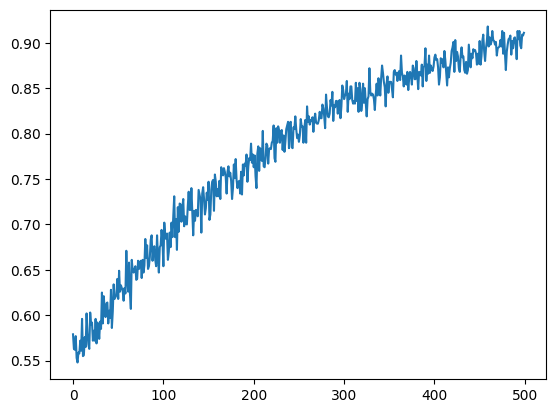

In [162]:
g = Game()
player1 = MyPlayer(trained=True)
player2 = RandomPlayer()
player3 = deepcopy(player1)
#print(player1.replay_mem)


In [ ]:
print(player1.model.table[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


###I set Exploration Rate to .1 to my opponent because it will make it play 10% of the time random, being it a copy of my trained agent.
###I also tried to let it be fully exploitative but then my model starts going worse against the RandomPlayer.

100%|██████████| 500000/500000 [31:14<00:00, 266.79it/s]


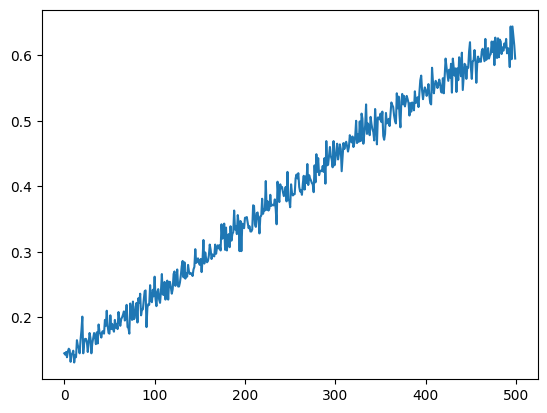

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
{(1485, 1488): (1485, 7, 0, 1488, False), (14610, 16797): (14610, 1, 0, 16797, False), (16959, 16960): (16959, 8, 0, 16960, False), (10938, 10956): (10938, 6, 0, 10956, False), (11685, 11847): (11685, 4, 0, 11847, False), (12090, 12144): (12090, 5, 0, 12144, False), (10863, 10863): (10863, 1, -1, 10863, False), (7471, 7477): (7471, 7, 0, 7477, False), (8964, 8964): (8964, 1, -1, 8964, False), (8964, 8967): (8964, 7, 0, 8967, False), (0, 6561): (0, 0, 0, 6561, False), (9396, 10125): (9396, 2, 10, 10125, True), (249, 2436): (249, 1, 0, 2436, False), (15558, 15639): (15558, 4, 0, 15639, False), (10881, 10884): (10881, 7, 0, 10884, False), (11831, 12074): (11831, 3, 0, 12074, False), (12092, 12119): (12092, 5, 0, 12119, False), (7191, 7197): (7191, 7, 0, 7197, False), (8916, 9645): (8916, 2, 10, 9645, True), (6724, 11098): (6724, 1, 0, 11098, False), (11101, 11119): (11101, 6, 0, 11119, False), (7292, 7292): (7292, 2, -1, 7292, False), (7292, 7310): (7292, 6, 0

In [168]:
g = Game()
player3.exploration_rate = .1
player1.train(player2=player3)
print(player1.model.table[0])
print(player1.replay_mem)

###And this is how it goes against random:

In [170]:
win1 = 0
draw1 = 0
plays = 3_000
for i in range(plays):
  g = Game()
  winner = g.play(player1, player2)
  if winner == 0:
    win1 += 1
  elif winner == -2:
    draw1 += 1
print("Win perc as 1st:", win1 * 100 / plays)
print("Draw perc as 1st:", draw1 * 100 / plays)

Win perc as 1st: 99.33333333333333
Draw perc as 1st: 0.6666666666666666


In [173]:
win2 = 0
draw2 = 0
plays = 3_000
for i in range(plays):
  g = Game()
  winner = g.play(player2, player1)
  if winner == 1:
    win2 += 1
  elif winner == -2:
    draw2 += 1
print("Win perc as 1st:", win2 * 100 / plays)
print("Draw perc as 1st:", draw2 * 100 / plays)

Win perc as 1st: 79.53333333333333
Draw perc as 1st: 20.466666666666665


###And here against player3 that I make fully exploitative again...not really a great result, after all :\\

In [174]:
player3.exploration_rate = 0

win1 = 0
draw1 = 0
plays = 3_000
for i in range(plays):
  g = Game()
  winner = g.play(player1, player3)
  if winner == 0:
    win1 += 1
  elif winner == -2:
    draw1 += 1
print("Win perc as 1st:", win1 * 100 / plays)
print("Draw perc as 1st:", draw1 * 100 / plays)

Win perc as 1st: 0.0
Draw perc as 1st: 100.0


In [175]:
win2 = 0
draw2 = 0
plays = 3_000
for i in range(plays):
  g = Game()
  winner = g.play(player3, player1)
  if winner == 1:
    win2 += 1
  elif winner == -2:
    draw2 += 1
print("Win perc as 1st:", win2 * 100 / plays)
print("Draw perc as 1st:", draw2 * 100 / plays)

Win perc as 1st: 0.0
Draw perc as 1st: 100.0
